In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Styling
plt.style.use('tdrstyle.mplstyle')

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.10/09


In [3]:
infile_r = None  # input file handle

def load_pgun():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root'
  #if use_condor:
  #  infile = 'root://cmsio5.rc.ufl.edu//store/user/jiafulow/L1MuonTrigger/P2_10_1_5/SingleMuon_Toy_2GeV/'+infile
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  return tree

In [4]:
maxEvents = 2000000
#maxEvents = 500000
#maxEvents = 10000

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

eta_bins = (1.2, 1.55, 1.7, 1.8, 1.98, 2.15, 2.4)
eta_bins = eta_bins[::-1]
#pt_bins = (-0.5 , -0.38, -0.26, -0.15, -0.05, 0.05, 0.15, 0.26, 0.38, 0.5)
#pt_bins = (-0.5 , -0.333333, -0.24, -0.15, -0.07, 0.07, 0.15, 0.24, 0.333333, 0.5)
#pt_bins = (-0.5, -0.37, -0.26, -0.15, -0.07, 0.07, 0.15, 0.26, 0.37, 0.5)
#pt_bins = (-0.5, -0.36, -0.25, -0.15, -0.07, 0.07, 0.15, 0.25, 0.36, 0.5)
pt_bins = (-0.5, -0.365, -0.26, -0.155, -0.07, 0.07, 0.155, 0.26, 0.365, 0.5)
nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)
superstrip_size = 32

assert(len(eta_bins) == 6+1)
assert(len(pt_bins) == 9+1)

from six.moves import range, zip, map, filter

from incrementalstats import IncrementalStats

def find_sector(phi):  # phi in radians
  dphi = delta_phi(phi, np.pi/12)  # sector 1 starts at 15 deg
  dphi = int(np.floor(dphi/(np.pi/3)))  # divide by 60 deg
  if dphi < 0:
    sector = 7 + dphi
  else:
    sector = 1 + dphi
  return sector

def find_endcap(eta):
  endcap = +1 if eta >= 0. else -1
  return endcap

def find_endsec(endcap, sector):
  endsec = (sector - 1) if endcap == 1 else (sector - 1 + 6)
  return endsec

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_eta_bin(eta):
  ieta = np.digitize((abs(eta),), eta_bins[1:])[0]  # skip lowest edge
  ieta = np.clip(ieta, 0, len(eta_bins)-2)
  return ieta

def _find_bin_fast(x, bins):
  x = np.clip(x, bins[1], bins[2]-1e-7)
  binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
  return int(binx)

def find_eta_bin_12(eta, bins=(12,1.2,2.4)):
  return _find_bin_fast(abs(eta), bins)

def find_pt_bin_100(pt, bins=(100,-0.5,0.5)):
  return _find_bin_fast(pt, bins)

# Decide EMTF hit layer number
class EMTFLayer(object):
  def __init__(self):
    lut = np.zeros((5,5,5), dtype=np.int32) - 99  # (type, station, ring) -> layer
    lut[1,1,4] = 0  # ME1/1a
    lut[1,1,1] = 0  # ME1/1b
    lut[1,1,2] = 1  # ME1/2
    lut[1,1,3] = 1  # ME1/3
    lut[1,2,1] = 2  # ME2/1
    lut[1,2,2] = 2  # ME2/2
    lut[1,3,1] = 3  # ME3/1
    lut[1,3,2] = 3  # ME3/2
    lut[1,4,1] = 4  # ME4/1
    lut[1,4,2] = 4  # ME4/2
    lut[2,1,2] = 5  # RE1/2
    lut[2,2,2] = 6  # RE2/2
    lut[2,3,1] = 7  # RE3/1
    lut[2,3,2] = 7  # RE3/2
    lut[2,3,3] = 7  # RE3/3
    lut[2,4,1] = 8  # RE4/1
    lut[2,4,2] = 8  # RE4/2
    lut[2,4,3] = 8  # RE4/3
    lut[3,1,1] = 9  # GE1/1
    lut[3,2,1] = 10 # GE2/1
    lut[4,1,1] = 11 # ME0
    self.lut = lut

  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    entry = self.lut[index]
    return entry

find_emtf_layer = EMTFLayer()

# Decide EMTF hit zones
class EMTFZone(object):
  def __init__(self):
    lut = np.zeros((5,5,5,6,2), dtype=np.int32) - 99  # (type, station, ring) -> [zone] x [min_theta,max_theta]
    lut[1,1,4][0] = 4,17   # ME1/1a
    lut[1,1,4][1] = 16,26  # ME1/1a
    lut[1,1,4][2] = 24,37  # ME1/1a
    lut[1,1,4][3] = 34,43  # ME1/1a
    lut[1,1,4][4] = 40,53  # ME1/1a
    lut[1,1,1][0] = 4,17   # ME1/1b
    lut[1,1,1][1] = 16,26  # ME1/1b
    lut[1,1,1][2] = 24,37  # ME1/1b
    lut[1,1,1][3] = 34,43  # ME1/1b
    lut[1,1,1][4] = 40,53  # ME1/1b
    lut[1,1,2][4] = 46,54  # ME1/2
    lut[1,1,2][5] = 52,88  # ME1/2
    lut[1,1,3][4] = 46,54  # ME1/3
    lut[1,1,3][5] = 52,88  # ME1/3
    #
    lut[1,2,1][0] = 4,17   # ME2/1
    lut[1,2,1][1] = 16,25  # ME2/1
    lut[1,2,1][2] = 24,36  # ME2/1
    lut[1,2,1][3] = 34,43  # ME2/1
    lut[1,2,1][4] = 40,49  # ME2/1
    lut[1,2,2][5] = 53,88  # ME2/2
    #
    lut[1,3,1][0] = 4,17   # ME3/1
    lut[1,3,1][1] = 16,25  # ME3/1
    lut[1,3,1][2] = 24,36  # ME3/1
    lut[1,3,1][3] = 34,40  # ME3/1
    lut[1,3,2][4] = 44,54  # ME3/2
    lut[1,3,2][5] = 52,88  # ME3/2
    #
    lut[1,4,1][0] = 4,17   # ME4/1
    lut[1,4,1][1] = 16,25  # ME4/1
    lut[1,4,1][2] = 24,35  # ME4/1
    lut[1,4,2][3] = 38,43  # ME4/2
    lut[1,4,2][4] = 41,54  # ME4/2
    lut[1,4,2][5] = 52,88  # ME4/2
    #
    lut[2,1,2][5] = 52,84  # RE1/2
    lut[2,2,2][5] = 56,76  # RE2/2
    lut[2,3,1][0] = 4,20   # RE3/1
    lut[2,3,1][1] = 20,24  # RE3/1
    lut[2,3,1][2] = 24,32  # RE3/1
    lut[2,3,2][3] = 40,40  # RE3/2
    lut[2,3,2][4] = 40,52  # RE3/2
    lut[2,3,2][5] = 48,84  # RE3/2
    lut[2,3,3][3] = 40,40  # RE3/3
    lut[2,3,3][4] = 40,52  # RE3/3
    lut[2,3,3][5] = 48,84  # RE3/3
    lut[2,4,1][0] = 8,16   # RE4/1
    lut[2,4,1][1] = 16,28  # RE4/1
    lut[2,4,1][2] = 24,28  # RE4/1
    lut[2,4,2][3] = 36,44  # RE4/2
    lut[2,4,2][4] = 44,52  # RE4/2
    lut[2,4,2][5] = 52,84  # RE4/2
    lut[2,4,3][3] = 36,44  # RE4/3
    lut[2,4,3][4] = 44,52  # RE4/3
    lut[2,4,3][5] = 52,84  # RE4/3
    #
    lut[3,1,1][1] = 17,26  # GE1/1
    lut[3,1,1][2] = 24,37  # GE1/1
    lut[3,1,1][3] = 35,45  # GE1/1
    lut[3,1,1][4] = 40,52  # GE1/1
    lut[3,2,1][0] = 7,19   # GE2/1
    lut[3,2,1][1] = 18,24  # GE2/1
    lut[3,2,1][2] = 23,35  # GE2/1
    lut[3,2,1][3] = 34,45  # GE2/1
    lut[3,2,1][4] = 40,46  # GE2/1
    #
    lut[4,1,1][0] = 4,17   # ME0
    lut[4,1,1][1] = 16,23  # ME0
    self.lut = lut
    
  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    entry = self.lut[index]
    answer = (entry[:,0] <= hit.emtf_theta) & (hit.emtf_theta <= entry[:,1])
    zones = np.nonzero(answer)
    if isinstance(zones, tuple):
      zones = zones[0]
    return zones

find_emtf_zones = EMTFZone()

# Decide EMTF hit bend
class EMTFBend(object):
  def __init__(self):
    self.lut = np.array([5, -5, 4, -4, 3, -3, 2, -2, 1, -1, 0], dtype=np.int32)

  def __call__(self, hit):
    if hit.type == kCSC:
      #clct = int(hit.pattern)
      #bend = self.lut[clct]
      bend = hit.bend
      if hit.station == 1:
        # Special case for ME1/1a:
        # rescale the bend to the same scale as ME1/1b
        if hit.ring == 4:
          bend *= 0.026331/0.014264
      elif hit.station in (2,3,4):
        if -8 <= bend <= 8:
          bend = 0
        elif bend > 8:
          bend = +1
        else:
          bend = -1
      bend *= hit.endcap
    elif hit.type == kGEM:
      bend = hit.bend
      bend *= hit.endcap
    elif hit.type == kME0:
      bend = hit.bend
    else:
      bend = 0
    return bend

find_emtf_bend = EMTFBend()

class EMTFZee(object):
  def __init__(self):
    self.lut = np.array([599.0, 696.8, 827.1, 937.5, 1027, 708.7, 790.9, 968.8, 1060, 566.4, 794.8, 539.3], dtype=np.float32)
    assert(self.lut.shape[0] == nlayers)
  
  def __call__(self, hit):
    return self.lut[hit.emtf_layer]

find_emtf_zee = EMTFZee()

class EMTFPhi(object):
  def __init__(self):
    pass
  
  def __call__(self, hit):
    if hit.type == kCSC:
      if hit.station == 1:
        if hit.ring == 1:
          bend_corr_lut = (-1.3861, 1.3692)  # ME1/1b (r,f)
        elif hit.ring == 4:
          bend_corr_lut = (-1.6419, 1.6012)  # ME1/1a (r,f)
        else:
          bend_corr_lut = (-0.9237, 0.8287)  # ME1/2 (r,f)
        bend_corr = bend_corr_lut[int(hit.fr)] * hit.bend
        bend_corr = bend_corr if hit.endcap == 1 else (bend_corr * -1)
        bend_corr = int(round(bend_corr))
        return hit.emtf_phi + bend_corr
      else:
        pass
    else:
      pass
    return hit.emtf_phi

find_emtf_phi = EMTFPhi()

class EMTFLayerPartner(object):
  def __init__(self):
    self.lut = np.array([2, 2, 0, 0, 0, 0, 2, 3, 4, 0, 2, 0], dtype=np.int32)
    assert(self.lut.shape[0] == nlayers)

  def __call__(self, emtf_layer, zone):
    partner = self.lut[emtf_layer]
    if zone >= 5:  # zones 5,6, use ME1/2
      if partner == 0:
        partner = 1
    return partner

find_emtf_layer_partner = EMTFLayerPartner()

# Decide EMTF road mode
def is_emtf_singlemu(mode):
  return mode in (11,13,14,15)

def is_emtf_doublemu(mode):
  return mode in (7,10,12) + (11,13,14,15)

def is_emtf_muopen(mode):
  return mode in (3,5,6,9) + (7,10,12) + (11,13,14,15)

# Decide EMTF legit hit
def is_emtf_legit_hit(hit):
  def check_bx(hit):
    if hit.type == kCSC:
      return hit.bx in (-1,0)
    else:
      return hit.bx == 0
  #
  def check_quality(hit):
    if hit.type == kRPC:
      return hit.quality <= 9  # cluster width
    else:
      return True
  #
  return check_bx(hit) and check_quality(hit)

In [5]:
# Main analysis

def analysis(verbose=1):
  tree = load_pgun()
  
  out_part, out_hits = [], []
  
  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if verbose and (ievt % 10000 == 0):  print("Processing event: {0}".format(ievt))
    
    # Skip events with very few hits
    if not len(evt.hits) >= 4:
      continue
    
    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
    if not has_ME1:
      continue
    
    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    
    # Find the best sector (using csc-only 'mode')
    sector_mode_array = np.zeros((12,), dtype=np.int32)
    sector_hits_array = np.empty((12,), dtype=np.object)
    for ind in np.ndindex(sector_hits_array.shape):
      sector_hits_array[ind] = []
      
    legit_hits = filter(is_emtf_legit_hit, evt.hits)
    
    # Loop over hits
    for ihit, hit in enumerate(legit_hits):
      assert(hit.emtf_phi < 5040)  # 84*60
      
      if hit.sim_tp1 == 0 and hit.sim_tp2 == 0:
        endsec = find_endsec(hit.endcap, hit.sector)
        if hit.type == kCSC:
          sector_mode_array[endsec] |= (1 << (4 - hit.station))
        elif hit.type == kME0:
          sector_mode_array[endsec] |= (1 << (4 - hit.station))
        sector_hits_array[endsec].append(hit)
    
    # Get the best sector
    best_sector = np.argmax(sector_mode_array)
    mode = sector_mode_array[best_sector]
    
    # Skip events without SingleMu modes
    if not is_emtf_singlemu(mode):
      continue
    
    # Get the hits
    sector_hits = sector_hits_array[best_sector]
    
    amap = {}  # zone -> hits
    
    # Loop over sector hits
    for ihit, hit in enumerate(sector_hits):
      hit.emtf_layer = find_emtf_layer(hit)
      assert(hit.emtf_layer != -99)
      
      hit.old_emtf_phi = hit.emtf_phi
      hit.emtf_zee = find_emtf_zee(hit)
      hit.emtf_phi = find_emtf_phi(hit)
      
      zones = find_emtf_zones(hit)
      for z in zones:
        amap.setdefault(np.asscalar(z), []).append(hit)
      continue  # end loop over sector_hits
    
    # Loop over map of zone -> hits
    ievt_part = []
    ievt_hits = []
    
    for k, v in amap.iteritems():
      zone = k
      hits = v
      
      mode = 0  # csc-only 'mode'
      for ihit, hit in enumerate(hits):
        if hit.type == kCSC:
          mode |= (1 << (4 - hit.station))
        elif hit.type == kME0:
          mode |= (1 << (4 - hit.station))
      
      if not is_emtf_singlemu(mode):
        continue
      
      # Output
      hits_array = np.zeros((60,3), dtype=np.int32) - 99  # output up to 60 hits
      for ihit, hit in enumerate(hits):
        if ihit == 60:
          break
        hits_array[ihit] = (hit.emtf_layer, hit.emtf_phi, hit.old_emtf_phi)
        
      ievt_part.append((part.invpt, part.eta, part.phi, zone, mode))
      ievt_hits.append(hits_array)
      continue  # end loop over map of zone -> hits
    
    # Verbose
    if ievt < 20:
      ievt_nhits = [(x[:,0] != -99).sum() for x in ievt_hits]
      print ievt, part.pt, ievt_part, ievt_nhits
    
    # Output
    out_part += ievt_part
    out_hits += ievt_hits
    continue  # end loop over events

  if verbose: print "DONE"
  return np.asarray(out_part, dtype=np.float32), np.asarray(out_hits, dtype=np.int32)

In [6]:
outfile = 'make_patterns_out.npz'
loaded = np.load('make_patterns_out.2.npz')
out_part = loaded['out_part']
out_hits = loaded['out_hits']

In [7]:
print out_part.shape, out_hits.shape

(3209829, 5) (3209829, 60, 3)


### Check bend corrections

### Find mean deflection angles

In [8]:
%%time

np.random.seed(2023)

_get_emtf_phi = lambda x: x[1]

patterns_match_me2 = np.empty((100, 12, nlayers), dtype=np.object)
patterns_match_me3 = np.empty((100, 12, nlayers), dtype=np.object)
for ind in np.ndindex(patterns_match_me2.shape):
  patterns_match_me2[ind] = []
  patterns_match_me3[ind] = []

# Loop over part and hits
# - part is (part_invpt, part_eta, part_phi, zone, mode)
# - hits is a collection of (emtf_layer, emtf_phi, old_emtf_phi)

print("Processing events ...")

for part, hits in zip(out_part, out_hits):
  (part_invpt, part_eta, part_phi, zone, mode) = part
  hits = hits[hits[:,0] != -99]
  
  ipt100 = find_pt_bin_100(part_invpt)
  ieta12 = find_eta_bin_12(part_eta)
  #ipt = find_pt_bin(part_invpt)
  #ieta = find_eta_bin(part_eta)
  
  amap = {}  # emtf_layer -> hits
  
  for ihit, hit in enumerate(hits):
    amap.setdefault(hit[0], []).append(hit)
    
  for k, v in amap.iteritems():
    n = len(v)
    amap[k] = v[np.random.randint(n)]  # pick a random hit for each emtf_layer
    
  def _find_dphi():
    dphi = hit_phi1 - hit_phi2
    dphi /= (np.sinh(1.8587) / np.sinh(abs(part_eta)))
    return dphi
  
  # Make pair of hits
  for k, v in amap.iteritems():
    emtf_layer = k
    hit1 = v
    hit_phi1 = _get_emtf_phi(hit1)
    
    # w.r.t ME2
    emtf_layer_me2 = 2
    hit2 = amap.get(emtf_layer_me2, None)
    if hit2 is not None:
      hit_phi2 = _get_emtf_phi(hit2)
      dphi = _find_dphi()
      patterns_match_me2[ipt100, ieta12, emtf_layer].append(dphi)
    
    # w.r.t ME3
    emtf_layer_me3 = 3
    hit2 = amap.get(emtf_layer_me3, None)
    if hit2 is not None:
      hit_phi2 = _get_emtf_phi(hit2)
      dphi = _find_dphi()
      patterns_match_me3[ipt100, ieta12, emtf_layer].append(dphi)
  continue  # end loop over part and hits

Processing events ...
CPU times: user 20min 5s, sys: 11 s, total: 20min 16s
Wall time: 19min 56s


In [9]:
lengths = np.array([len(patterns_match_me2[ind]) for ind in np.ndindex(patterns_match_me2.shape)])
#lengths = lengths.reshape((patterns_match_me2.shape))
print np.percentile(lengths, [10,20,30,40,50,60,70,80,90], overwrite_input=True)

[   0.     0.     9.   688.4 1608.5 2125.  2408.  2631.  2927. ]


In [10]:
patterns_match_me2_1 = np.zeros(patterns_match_me2.shape, dtype=np.int32)
patterns_match_me3_1 = np.zeros(patterns_match_me3.shape, dtype=np.int32)
for ind in np.ndindex(patterns_match_me2.shape):
  if len(patterns_match_me2[ind]) > 100:
    patterns_match_me2_1[ind] = np.percentile(patterns_match_me2[ind], [50], overwrite_input=True)
  if len(patterns_match_me3[ind]) > 100:
    patterns_match_me3_1[ind] = np.percentile(patterns_match_me3[ind], [50], overwrite_input=True)

In [11]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# https://matplotlib.org/users/dflt_style_changes.html#colors-in-default-property-cycle
# https://github.com/vega/vega/wiki/Scales#scale-range-literals
category10_palette  = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf')
category20_palette  = ('#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5')
category10a_palette = ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5')

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-matplotlib/1.5.2-omkpbe3/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


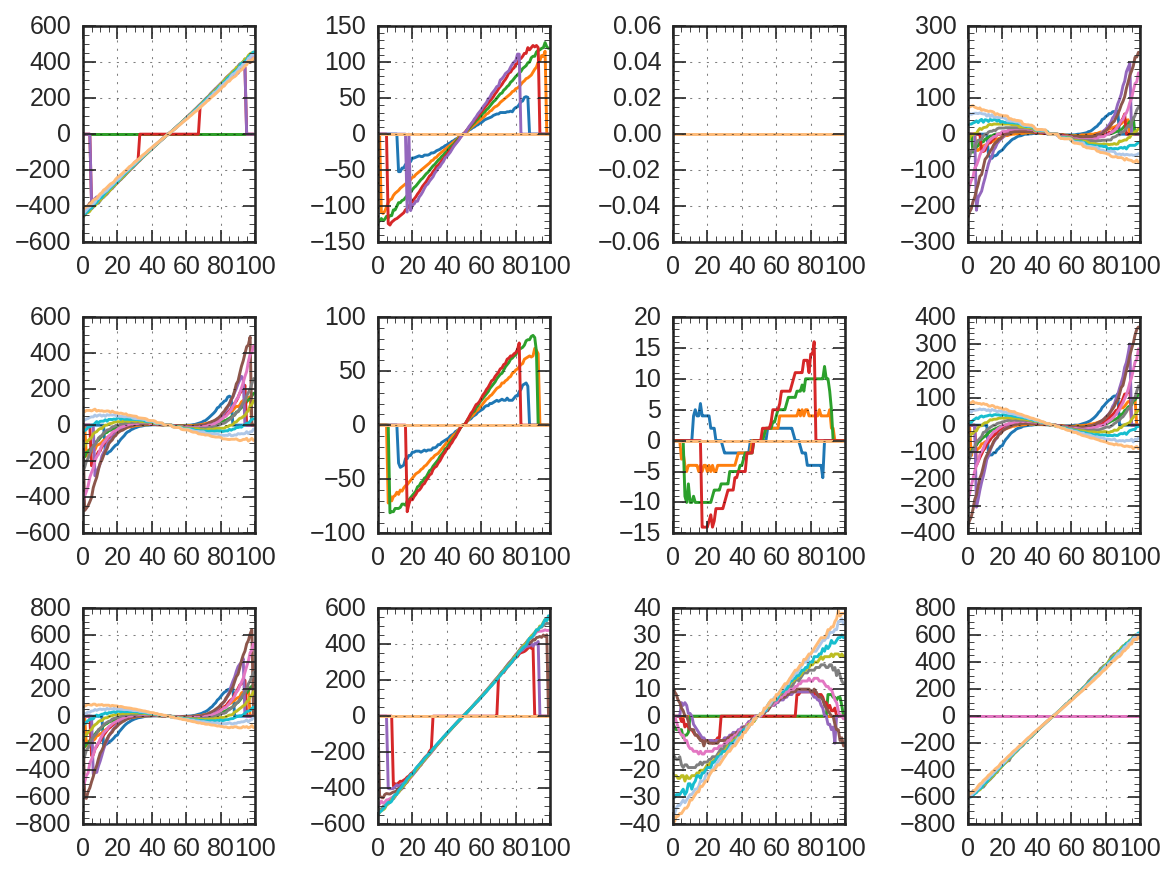

In [12]:
# w.r.t ME2
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(8,6), tight_layout=True)

for i in xrange(nlayers):
  for j in xrange(12):
    yy = patterns_match_me2_1[:,j,i]
    axs[i/4,i%4].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
plt.show()

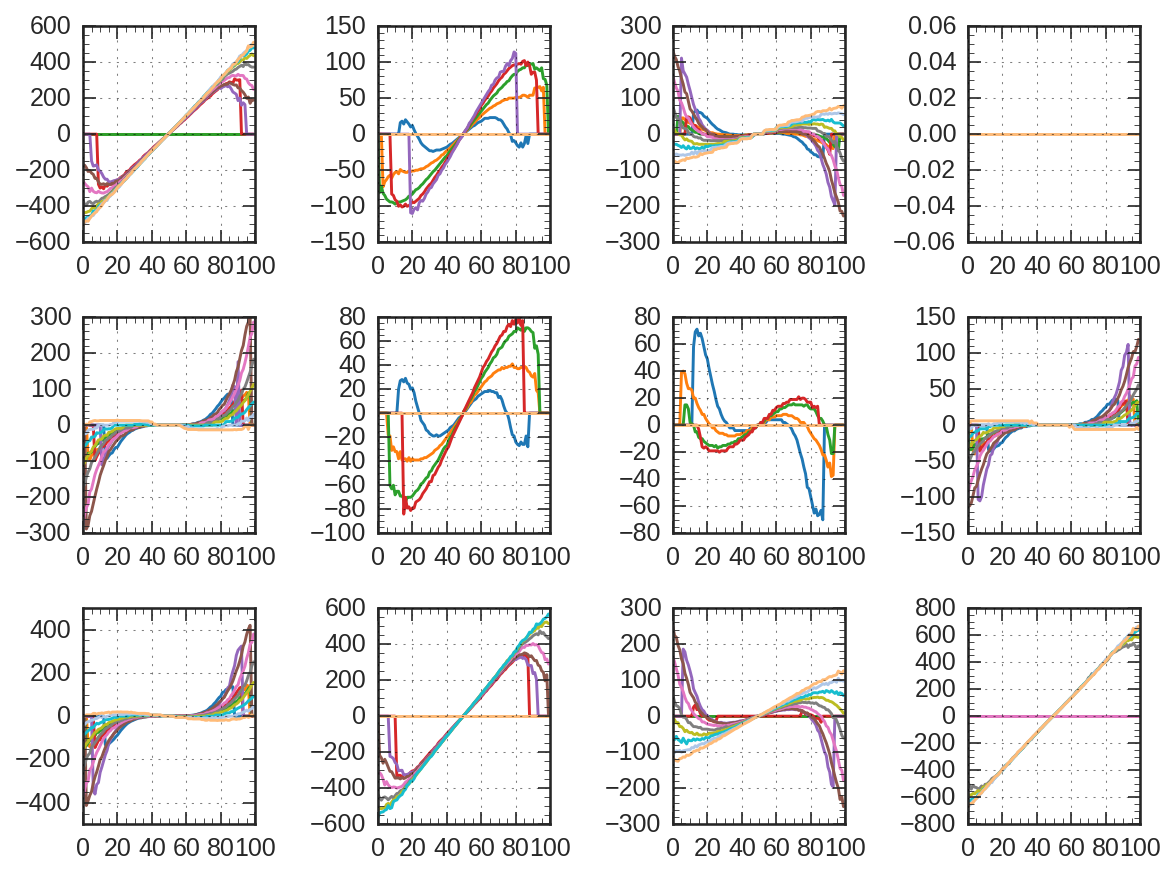

In [13]:
# w.r.t ME3
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(8,6), tight_layout=True)

for i in xrange(nlayers):
  for j in xrange(12):
    yy = patterns_match_me3_1[:,j,i]
    axs[i/4,i%4].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
plt.show()

In [14]:
# Smoothing
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
#kernel = C(10000.0, (1e-2, 1e7)) * RBF(1.0, (1e-2, 1e2)) + W(1.0, (1e-5, 1e5))
#gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=10)

patterns_match_me2_2 = np.zeros(patterns_match_me2.shape, dtype=np.int32)
patterns_match_me3_2 = np.zeros(patterns_match_me3.shape, dtype=np.int32)

In [15]:
# ME1/1 w.r.t ME2, ME3

emtf_layer_me1 = 0

for i in xrange(2):  # i=0: w.r.t ME2; i=1: w.r.t ME3
  for j in xrange(3,12):  # ME1/1, valid for eta >= 1.5
    if i == 0:
      yy = patterns_match_me2_1[:,j,emtf_layer_me1]
    else:
      yy = patterns_match_me3_1[:,j,emtf_layer_me1]
    #xx = np.arange(len(yy))
    xx = np.linspace(-0.495, 0.495, num=100)
    
    eta_j = 1.25+j*0.1
    eta_s = 1.25+(11)*0.1
    s = 0.5 * np.cosh(eta_j)/np.cosh(eta_s)  # p = pT cosh(eta)
    s = 50 - int(s*100) + 3
    
    mask = (np.abs(yy) >= 1)
    mask[:s] = False
    mask[-s:] = False

    #kernel = C(10000.0, (1e-1, 5e6)) * RBF(1.0, (1e-3, 1e3)) + W(1.0, (1e-5, 1e5))
    #kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1e3)) + W(2.0, (1e-4, 1e4))
    kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1.5))
    alpha = 50
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=15)
    gp.fit(np.atleast_2d(xx[mask]).T, yy[mask])

    if i == 0:
      patterns_match_me2_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)
    else:
      patterns_match_me3_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)

    params = gp.kernel_.get_params()
    #params = params['k1__k1__constant_value'], params['k1__k2__length_scale'], params['k2__noise_level']
    params = params['k1__constant_value'], params['k2__length_scale']
    print '{:d},({:.1f},{:.1f})'.format(i, 1.2+j*0.1, 1.2+(j+1)*0.1), s, params

# Fix boundaries
patterns_match_me2_2[:,3,emtf_layer_me1] = patterns_match_me2_2[:,4,emtf_layer_me1]
patterns_match_me3_2[:,3,emtf_layer_me1] = patterns_match_me3_2[:,4,emtf_layer_me1]

0,(1.5,1.6) 30 (42629.86833407791, 0.3428820327558449)
0,(1.6,1.7) 28 (590197.5927049366, 1.5)
0,(1.7,1.8) 25 (663373.3673109073, 1.5)
0,(1.8,1.9) 23 (265156.7924302867, 0.5361515808078258)
0,(1.9,2.0) 20 (281768.5256046739, 0.5597200770918636)
0,(2.0,2.1) 16 (439062.4071532515, 0.6748497226083691)
0,(2.1,2.2) 12 (482284.9317177428, 0.7465168495965137)
0,(2.2,2.3) 8 (348675.9334800601, 0.6975141456938309)
0,(2.3,2.4) 3 (851580.9135825705, 0.9764953007424031)
1,(1.5,1.6) 30 (597209.9226418891, 1.5)
1,(1.6,1.7) 28 (636931.9368260748, 1.5)
1,(1.7,1.8) 25 (278287.5460961325, 0.9847981840165808)
1,(1.8,1.9) 23 (696926.995400897, 1.5)
1,(1.9,2.0) 20 (743177.6857546803, 1.5)
1,(2.0,2.1) 16 (969738.3228713407, 1.5)
1,(2.1,2.2) 12 (1298683.2789049668, 1.5)
1,(2.2,2.3) 8 (1574187.3358186942, 1.2005851596537196)
1,(2.3,2.4) 3 (1540134.4473782626, 1.1769916369674962)


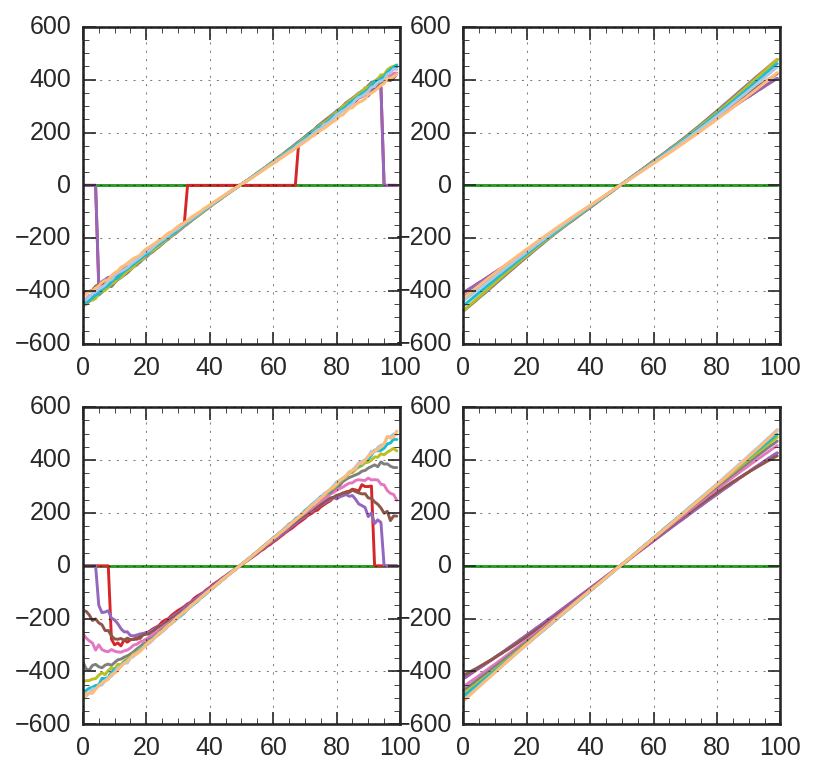

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for j in xrange(12):
  yy = patterns_match_me2_1[:,j,emtf_layer_me1]
  axs[0,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me2_2[:,j,emtf_layer_me1]
  axs[0,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_1[:,j,emtf_layer_me1]
  axs[1,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_2[:,j,emtf_layer_me1]
  axs[1,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])

plt.show()

In [17]:
# ME0 w.r.t ME2, ME3

emtf_layer_me1 = 11

for i in xrange(2):  # i=0: w.r.t ME2; i=1: w.r.t ME3
  for j in xrange(8,12):  # ME0, valid for eta >= 2.0
    if i == 0:
      yy = patterns_match_me2_1[:,j,emtf_layer_me1]
    else:
      yy = patterns_match_me3_1[:,j,emtf_layer_me1]
    #xx = np.arange(len(yy))
    xx = np.linspace(-0.495, 0.495, num=100)
    
    eta_j = 1.25+j*0.1
    eta_s = 1.25+(11)*0.1
    s = 0.5 * np.cosh(eta_j)/np.cosh(eta_s)  # p = pT cosh(eta)
    s = 50 - int(s*100) + 1
    
    mask = (np.abs(yy) >= 1)
    mask[:s] = False
    mask[-s:] = False

    #kernel = C(10000.0, (1e-1, 5e6)) * RBF(1.0, (1e-3, 1e3)) + W(1.0, (1e-5, 1e5))
    #kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1e3)) + W(2.0, (1e-4, 1e4))
    kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1.5))
    alpha = 50
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=15)
    gp.fit(np.atleast_2d(xx[mask]).T, yy[mask])

    if i == 0:
      patterns_match_me2_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)
    else:
      patterns_match_me3_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)

    params = gp.kernel_.get_params()
    #params = params['k1__k1__constant_value'], params['k1__k2__length_scale'], params['k2__noise_level']
    params = params['k1__constant_value'], params['k2__length_scale']
    print '{:d},({:.1f},{:.1f})'.format(i, 1.2+j*0.1, 1.2+(j+1)*0.1), s, params

# Fix boundaries
patterns_match_me2_2[:,7,emtf_layer_me1] = patterns_match_me2_2[:,8,emtf_layer_me1]
patterns_match_me3_2[:,7,emtf_layer_me1] = patterns_match_me3_2[:,8,emtf_layer_me1]

0,(2.0,2.1) 14 (871770.9011716181, 0.6962654795198944)
0,(2.1,2.2) 10 (777773.5155269039, 0.7150306012330016)
0,(2.2,2.3) 6 (503376.75018464966, 0.6373723655488737)
0,(2.3,2.4) 1 (718836.096352665, 0.7678855889069273)
1,(2.0,2.1) 14 (2247556.7294123913, 1.0999926246159968)
1,(2.1,2.2) 10 (3000000.0000000023, 1.343620124128359)
1,(2.2,2.3) 6 (516201.09714094666, 0.6226421338106596)
1,(2.3,2.4) 1 (459322.35300758213, 0.6081872880782538)


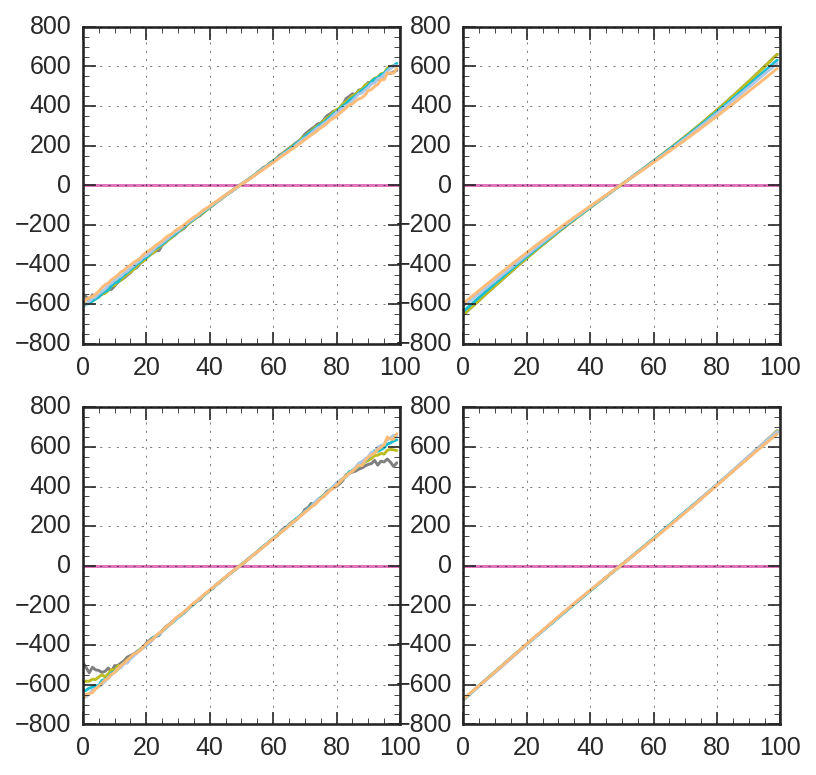

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for j in xrange(12):
  yy = patterns_match_me2_1[:,j,emtf_layer_me1]
  axs[0,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me2_2[:,j,emtf_layer_me1]
  axs[0,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_1[:,j,emtf_layer_me1]
  axs[1,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_2[:,j,emtf_layer_me1]
  axs[1,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])

plt.show()

In [19]:
# GE1/1 w.r.t ME2, ME3

emtf_layer_me1 = 9

for i in xrange(2):  # i=0: w.r.t ME2; i=1: w.r.t ME3
  for j in xrange(3,10):  # GE1/1, valid for 1.5 <= eta <= 2.2
    if i == 0:
      yy = patterns_match_me2_1[:,j,emtf_layer_me1]
    else:
      yy = patterns_match_me3_1[:,j,emtf_layer_me1]
    #xx = np.arange(len(yy))
    xx = np.linspace(-0.495, 0.495, num=100)
    
    eta_j = 1.25+j*0.1
    eta_s = 1.25+(11)*0.1
    s = 0.5 * np.cosh(eta_j)/np.cosh(eta_s)  # p = pT cosh(eta)
    s = 50 - int(s*100) + 3
    
    mask = (np.abs(yy) >= 1)
    mask[:s] = False
    mask[-s:] = False

    #kernel = C(10000.0, (1e-1, 5e6)) * RBF(1.0, (1e-3, 1e3)) + W(1.0, (1e-5, 1e5))
    #kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1e3)) + W(2.0, (1e-4, 1e4))
    kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1.5))
    alpha = 50
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=15)
    gp.fit(np.atleast_2d(xx[mask]).T, yy[mask])

    if i == 0:
      patterns_match_me2_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)
    else:
      patterns_match_me3_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)

    params = gp.kernel_.get_params()
    #params = params['k1__k1__constant_value'], params['k1__k2__length_scale'], params['k2__noise_level']
    params = params['k1__constant_value'], params['k2__length_scale']
    print '{:d},({:.1f},{:.1f})'.format(i, 1.2+j*0.1, 1.2+(j+1)*0.1), s, params

# Fix boundaries
patterns_match_me2_2[:,3,emtf_layer_me1] = patterns_match_me2_2[:,4,emtf_layer_me1]
patterns_match_me3_2[:,3,emtf_layer_me1] = patterns_match_me3_2[:,4,emtf_layer_me1]
patterns_match_me2_2[:,9,emtf_layer_me1] = patterns_match_me2_2[:,8,emtf_layer_me1]
patterns_match_me3_2[:,9,emtf_layer_me1] = patterns_match_me3_2[:,8,emtf_layer_me1]

0,(1.5,1.6) 30 (35330.00388085868, 0.2833203251957122)
0,(1.6,1.7) 28 (217668.8288161444, 0.4138209129876285)
0,(1.7,1.8) 25 (361988.6195943848, 0.5271301284538057)
0,(1.8,1.9) 23 (388648.7002542037, 0.5354256123066209)
0,(1.9,2.0) 20 (413880.7742918886, 0.5620633012712767)
0,(2.0,2.1) 16 (661992.9463682468, 0.6810668805767417)
0,(2.1,2.2) 12 (725380.2485567136, 0.7303303672381067)
1,(1.5,1.6) 30 (861649.9947762659, 1.5)
1,(1.6,1.7) 28 (947131.1489675682, 1.5)
1,(1.7,1.8) 25 (955660.8505066924, 1.5)
1,(1.8,1.9) 23 (1003029.5013799359, 1.5)
1,(1.9,2.0) 20 (1222999.209079817, 1.5)
1,(2.0,2.1) 16 (2715523.8606636887, 1.5)
1,(2.1,2.2) 12 (1993753.9623343225, 1.147455298431839)


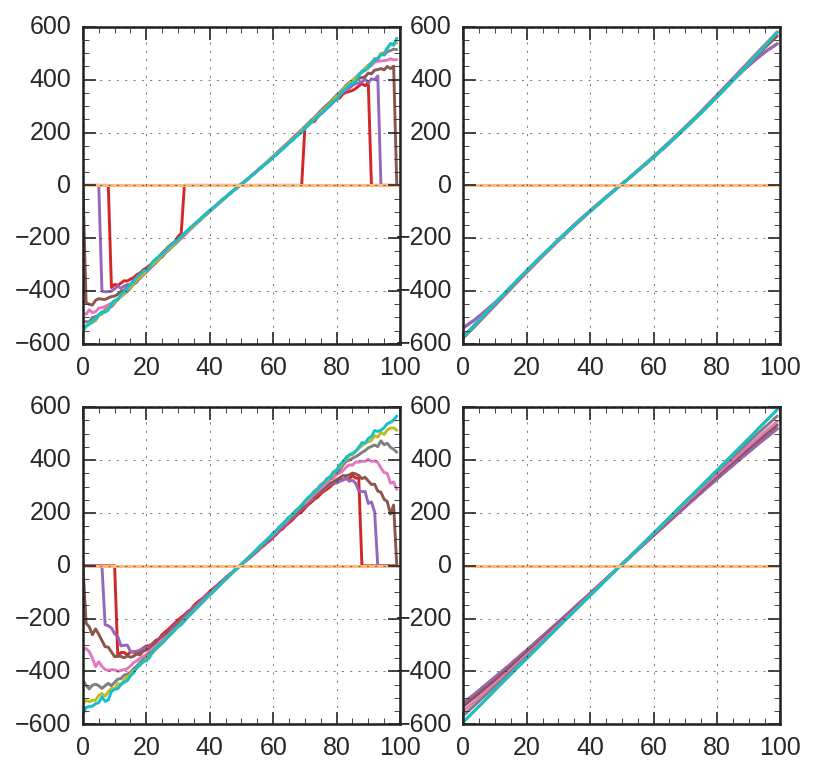

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for j in xrange(12):
  yy = patterns_match_me2_1[:,j,emtf_layer_me1]
  axs[0,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me2_2[:,j,emtf_layer_me1]
  axs[0,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_1[:,j,emtf_layer_me1]
  axs[1,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_2[:,j,emtf_layer_me1]
  axs[1,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])

plt.show()

In [21]:
# ME1/2 w.r.t ME2, ME3

emtf_layer_me1 = 1

for i in xrange(2):  # i=0: w.r.t ME2; i=1: w.r.t ME3
  for j in xrange(0,5):  # ME1/2, valid for eta <= 1.6
    if i == 0:
      yy = patterns_match_me2_1[:,j,emtf_layer_me1]
    else:
      yy = patterns_match_me3_1[:,j,emtf_layer_me1]
    #xx = np.arange(len(yy))
    xx = np.linspace(-0.495, 0.495, num=100)
    
    eta_j = 1.25+j*0.1
    eta_s = 1.25+(11)*0.1
    s = 0.5 * np.cosh(eta_j)/np.cosh(eta_s)  # p = pT cosh(eta)
    s = 50 - int(s*100) + 1 + 3
    
    mask = (np.abs(yy) >= 1)
    mask[:s] = False
    mask[-s:] = False

    #kernel = C(10000.0, (1e-1, 5e6)) * RBF(1.0, (1e-3, 1e3)) + W(1.0, (1e-5, 1e5))
    #kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1e3)) + W(2.0, (1e-4, 1e4))
    kernel = C(10000.0, (1e2, 3e6)) * RBF(1.0, (1e-3, 1.5))
    alpha = 50
    gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha, n_restarts_optimizer=15)
    gp.fit(np.atleast_2d(xx[mask]).T, yy[mask])

    if i == 0:
      patterns_match_me2_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)
    else:
      patterns_match_me3_2[:,j,emtf_layer_me1] = gp.predict(np.atleast_2d(xx).T, return_std=False)

    params = gp.kernel_.get_params()
    #params = params['k1__k1__constant_value'], params['k1__k2__length_scale'], params['k2__noise_level']
    params = params['k1__constant_value'], params['k2__length_scale']
    print '{:d},({:.1f},{:.1f})'.format(i, 1.2+j*0.1, 1.2+(j+1)*0.1), s, params

# Fix boundaries
patterns_match_me2_2[:,4,emtf_layer_me1] = patterns_match_me2_2[:,3,emtf_layer_me1]
patterns_match_me3_2[:,4,emtf_layer_me1] = patterns_match_me3_2[:,3,emtf_layer_me1]

0,(1.2,1.3) 37 (460.9923818458596, 0.2038885945566068)
0,(1.3,1.4) 35 (1882.831227112734, 0.33795730463320023)
0,(1.4,1.5) 33 (6460.4947358252775, 0.5140268531013117)
0,(1.5,1.6) 31 (17824.467477111255, 0.7321060524803114)
0,(1.6,1.7) 29 (43704.70225377933, 1.0330456751831956)
1,(1.2,1.3) 37 (547.346630271942, 0.19285358098620148)
1,(1.3,1.4) 35 (2295.5989992145355, 0.3137424853983228)
1,(1.4,1.5) 33 (9055.935183947031, 0.5080206110075054)
1,(1.5,1.6) 31 (20729.006405041873, 0.6467717405130435)
1,(1.6,1.7) 29 (25358.24712794041, 0.6667486943279508)


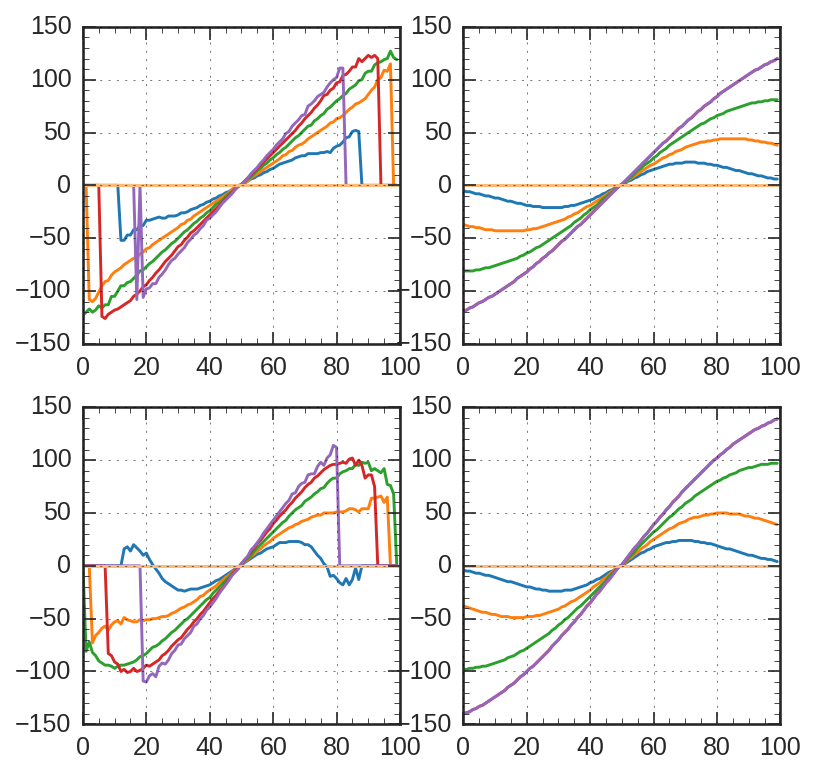

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

for j in xrange(12):
  yy = patterns_match_me2_1[:,j,emtf_layer_me1]
  axs[0,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me2_2[:,j,emtf_layer_me1]
  axs[0,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_1[:,j,emtf_layer_me1]
  axs[1,0].plot(np.arange(len(yy)), yy, color=category10a_palette[j])
  yy = patterns_match_me3_2[:,j,emtf_layer_me1]
  axs[1,1].plot(np.arange(len(yy)), yy, color=category10a_palette[j])

plt.show()

### Find pattern windows

In [23]:
%%time

np.random.seed(2023)

_get_emtf_phi = lambda x: x[1]

patterns_phi = np.empty((len(pt_bins)-1, len(eta_bins)-1, nlayers), dtype=np.object)
patterns_match = np.empty((len(pt_bins)-1, len(eta_bins)-1, nlayers), dtype=np.object)
for ind in np.ndindex(patterns_phi.shape):
  patterns_phi[ind] = []
  patterns_match[ind] = []

# Loop over part and hits
# - part is (part_invpt, part_eta, part_phi, zone, mode)
# - hits is a collection of (emtf_layer, emtf_phi, old_emtf_phi)

print("Processing events ...")

for part, hits in zip(out_part, out_hits):
  (part_invpt, part_eta, part_phi, zone, mode) = part
  hits = hits[hits[:,0] != -99]
  
  ipt100 = find_pt_bin_100(part_invpt)
  ieta12 = find_eta_bin_12(part_eta)
  ipt = find_pt_bin(part_invpt)
  ieta = find_eta_bin(part_eta)
  
  amap = {}  # emtf_layer -> hits
  
  for ihit, hit in enumerate(hits):
    amap.setdefault(hit[0], []).append(hit)
    
  for k, v in amap.iteritems():
    n = len(v)
    amap[k] = v[np.random.randint(n)]  # pick a random hit for each emtf_layer
    
  # Find hit phi at the key station
  key_hit_phi = None
  
  def _get_dphi():
    dphi = patterns_match_me2_2[ipt100, ieta12, emtf_layer_me1]
    dphi += patterns_match_me3_2[ipt100, ieta12, emtf_layer_me1]
    dphi *= 0.5
    dphi *= (np.sinh(1.8587) / np.sinh(abs(part_eta)))
    
    # Add some noise
    sigma = superstrip_size/np.sqrt(12)
    dphi += sigma * np.random.normal()
    return dphi
  
  if key_hit_phi is None:
    emtf_layer_me1 = 11        # ME0
    if ieta12 in xrange(8,12): # ME0
      hit2 = amap.get(emtf_layer_me1, None)
      if hit2 is not None:
        key_hit_phi = _get_emtf_phi(hit2)
        dphi = _get_dphi()
        key_hit_phi -= dphi
  
  if key_hit_phi is None:
    emtf_layer_me1 = 0         # ME1/1
    if ieta12 in xrange(3,12): # ME1/1
      hit2 = amap.get(emtf_layer_me1, None)
      if hit2 is not None:
        key_hit_phi = _get_emtf_phi(hit2)
        dphi = _get_dphi()
        key_hit_phi -= dphi
        
  if key_hit_phi is None:
    emtf_layer_me1 = 9         # GE1/1
    if ieta12 in xrange(3,10): # GE1/1
      hit2 = amap.get(emtf_layer_me1, None)
      if hit2 is not None:
        key_hit_phi = _get_emtf_phi(hit2)
        dphi = _get_dphi()
        key_hit_phi -= dphi
        
  if key_hit_phi is None:
    emtf_layer_me1 = 1        # ME1/2
    if ieta12 in xrange(0,5): # ME1/2
      hit2 = amap.get(emtf_layer_me1, None)
      if hit2 is not None:
        key_hit_phi = _get_emtf_phi(hit2)
        dphi = _get_dphi()
        key_hit_phi -= dphi
        
  if key_hit_phi is None:
    continue
  
  # Make pair of hits
  for k, v in amap.iteritems():
    emtf_layer = k
    hit1 = v
    hit_phi1 = _get_emtf_phi(hit1)
    dphi = (hit_phi1 - key_hit_phi)
    patterns_phi[ipt, int(zone), emtf_layer].append(dphi)
    
    emtf_layer_partner = find_emtf_layer_partner(emtf_layer, zone)
    hit2 = amap.get(emtf_layer_partner, None)
    if hit2 is not None:
      hit_phi2 = _get_emtf_phi(hit2)
      dphi = (hit_phi1 - hit_phi2)
      patterns_match[ipt, int(zone), emtf_layer].append(dphi)
  continue  # end loop over part and hits

Processing events ...
CPU times: user 17min 35s, sys: 6.55 s, total: 17min 41s
Wall time: 17min 31s


In [24]:
# Histogram
# - make 47 bins, bin 23 is the highest pT
nbinsx = 47
firstbinx = 23
xlow = -0.5*nbinsx*superstrip_size
xup = +0.5*nbinsx*superstrip_size

please_symmetrize = True

valid_layers = np.zeros(patterns_phi.shape, dtype=np.bool)
valid_layers[:, 0, [0,2,3,4,7,8,10,11]]   = True
valid_layers[:, 1, [0,2,3,4,7,8,9,10,11]] = True
valid_layers[:, 2, [0,2,3,4,7,8,9,10]]    = True
valid_layers[:, 3, [0,2,3,4,7,8,9,10]]    = True
valid_layers[:, 4, [0,1,2,3,4,7,8,9,10]]  = True
valid_layers[:, 5, [1,2,3,4,5,6,7,8]]     = True

patterns_phi_1 = np.zeros(patterns_phi.shape + (nbinsx,), dtype=np.int32)
for ind in np.ndindex(patterns_phi.shape):
  if valid_layers[ind]:
    #print ind, np.percentile(patterns_phi[ind], [5,50,95], overwrite_input=True)
    hist, _ = np.histogram(patterns_phi[ind], bins=nbinsx, range=(xlow,xup))
    patterns_phi_1[ind] = hist

if please_symmetrize:
  # Sum with its flipped and reversed self
  patterns_phi_1_flipped = np.flip(patterns_phi_1, axis=0)
  assert((patterns_phi_1[0] == patterns_phi_1_flipped[8]).all())
  assert((patterns_phi_1[1] == patterns_phi_1_flipped[7]).all())
  assert((patterns_phi_1[2] == patterns_phi_1_flipped[6]).all())
  assert((patterns_phi_1[3] == patterns_phi_1_flipped[5]).all())
  assert((patterns_phi_1[4] == patterns_phi_1_flipped[4]).all())
  patterns_phi_1 += patterns_phi_1_flipped[...,::-1]
  patterns_phi_1 /= 2

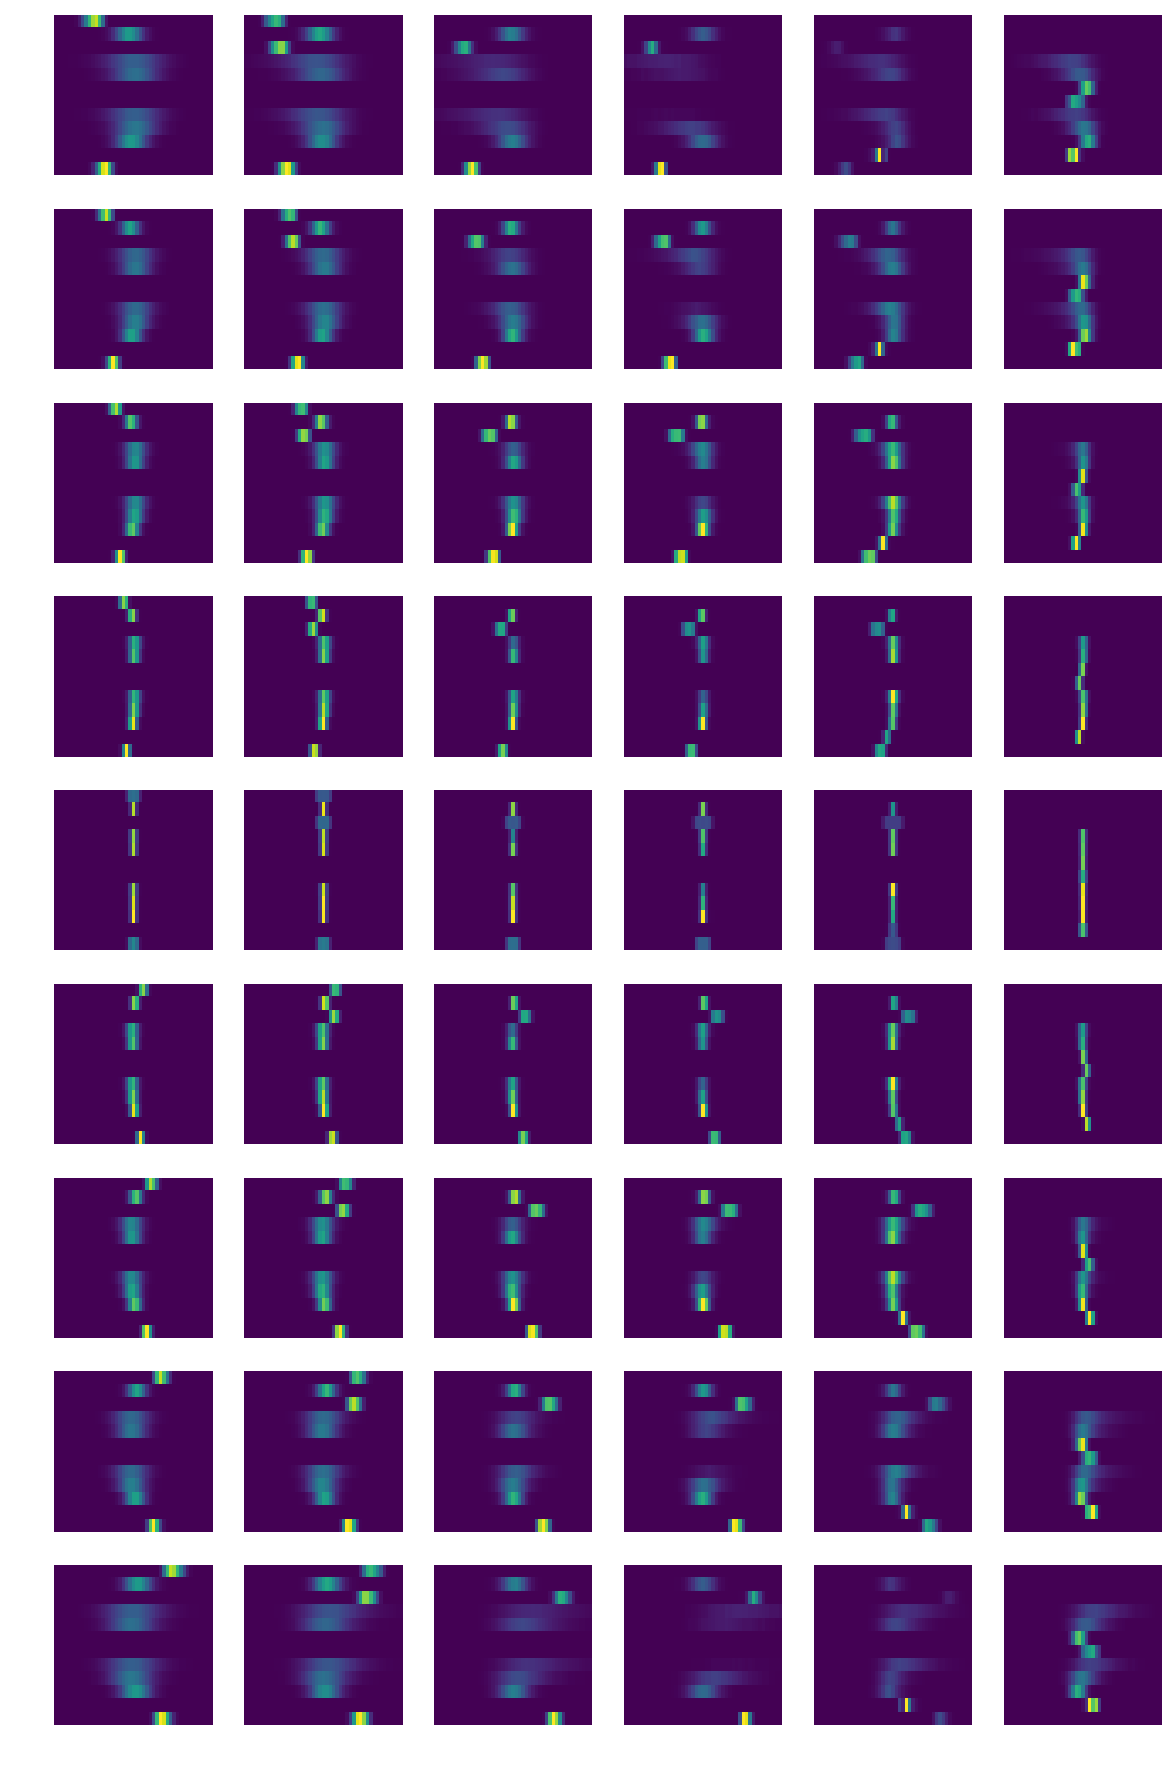

In [25]:
ncols = len(eta_bins)-1
nrows = len(pt_bins)-1

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8,8./ncols*nrows), tight_layout=True, sharex=True, sharey=True)

for i in xrange(nrows):
  for j in xrange(ncols):
    img = patterns_phi_1[i,j,:]
    axs[i,j].imshow(img, origin='lower', interpolation='nearest', aspect='auto')
    axs[i,j].axis('off')
    
plt.show()

In [26]:
# Find windows

#activation = 0.01
#activation = 0.1
activation = 0.12

patterns_phi_2 = np.zeros(patterns_phi.shape + (3,), dtype=np.int32)

for ind in np.ndindex(patterns_phi.shape):
  if valid_layers[ind]:
    #print ind, np.percentile(patterns_phi[ind], [5,50,95], overwrite_input=True)
    
    x = patterns_phi_1[ind].copy().astype(np.float32)
    #norm = x.sum()
    norm = np.sqrt(np.square(x).sum())
    assert(np.isfinite(norm).all())
    x = np.true_divide(x, norm)
    x[np.isnan(x)] = 0
    
    act = activation
    if ind[2] in [5,6,7,8]:  # higher requirement on RPC
      act += 0.02
    
    try:
      y = np.where(x > act)[0] - firstbinx  # offset by firstbinx
      if (y[-1] - y[0]) != len(y)-1:
        print("[WARNING] The range is not continuous. Please check!")
      if y[-1] == y[0]:
        print("[WARNING] The range is zero. Please check!")
      y = y[0], y[-1]
    except:
      y = 0, 0
    
    z = np.percentile(patterns_phi[ind], [2.5,50,97.5], overwrite_input=True)
    z = np.round(np.true_divide(z, superstrip_size))
    print ind, y, z
    
    patterns_phi_2[ind] = y[0], z[1], y[1]
    
print np.min(patterns_phi_2), np.max(patterns_phi_2)

(0, 0, 0) (-11, -6) [-12.  -9.  -6.]
(0, 0, 2) (-5, 4) [-7. -1.  6.]
(0, 0, 3) (-5, 6) [-8.  1.  9.]
(0, 0, 4) (-6, 7) [-11.   0.  10.]
(0, 0, 7) (-5, 6) [-9.  0. 10.]
(0, 0, 8) (-6, 7) [-12.   0.  11.]
(0, 0, 10) (-5, 3) [-7. -1.  4.]
(0, 0, 11) (-15, -9) [-15. -12.  -9.]
(0, 1, 0) (-13, -9) [-14. -11.  -8.]
(0, 1, 2) (-5, 4) [-7. -0.  6.]
(0, 1, 3) (-6, 5) [-10.  -0.   8.]
(0, 1, 4) (-9, 5) [-16.  -2.   9.]
(0, 1, 7) (-7, 5) [-12.  -1.   8.]
(0, 1, 8) (-9, 4) [-19.  -3.   9.]
(0, 1, 9) (-16, -10) [-16. -13. -10.]
(0, 1, 10) (-5, 3) [-7. -1.  4.]
(0, 1, 11) (-17, -12) [-18. -14. -11.]
(0, 2, 0) (-14, -10) [-15. -12. -10.]
(0, 2, 2) (-4, 4) [-6. -0.  6.]
(0, 2, 3) (-9, 4) [-15.  -2.   7.]
(0, 2, 4) (-14, 2) [-26.  -6.   6.]
(0, 2, 7) (-10, 3) [-19.  -4.   6.]
(0, 2, 8) (-14, 1) [-29.  -7.   6.]
(0, 2, 9) (-17, -12) [-18. -15. -12.]
(0, 2, 10) (-4, 3) [-5. -0.  5.]
(0, 3, 0) (-14, -11) [-15. -13. -11.]
(0, 3, 2) (-4, 4) [-6. -0.  6.]
(0, 3, 3) (-11, 3) [-17.  -4.   5.]
(0, 3, 4) (-19, -

(4, 5, 6) (0, 0) [-1. -0.  1.]
(4, 5, 7) (-1, 1) [-1. -0.  1.]
(4, 5, 8) (-1, 1) [-1. -0.  1.]
(5, 0, 0) (1, 3) [1. 2. 3.]
(5, 0, 2) (-1, 1) [-1.  0.  2.]
(5, 0, 3) (-2, 1) [-2. -0.  2.]
(5, 0, 4) (-2, 1) [-3. -0.  2.]
(5, 0, 7) (-2, 1) [-2. -0.  2.]
(5, 0, 8) (-2, 1) [-3. -0.  2.]
(5, 0, 10) (-1, 1) [-1.  0.  2.]
(5, 0, 11) (2, 4) [2. 3. 4.]
(5, 1, 0) (2, 4) [1. 3. 4.]
(5, 1, 2) (-1, 1) [-1.  0.  2.]
(5, 1, 3) (-2, 1) [-2. -0.  2.]
(5, 1, 4) (-2, 1) [-3. -0.  2.]
(5, 1, 7) (-2, 1) [-2. -0.  2.]
(5, 1, 8) (-2, 1) [-3. -0.  2.]
(5, 1, 9) (2, 4) [2. 3. 5.]
(5, 1, 10) (-1, 1) [-1.  0.  2.]
(5, 1, 11) (2, 5) [2. 3. 5.]
(5, 2, 0) (2, 4) [2. 3. 5.]
(5, 2, 2) (-1, 1) [-1.  0.  2.]
(5, 2, 3) (-1, 1) [-2. -0.  2.]
(5, 2, 4) (-2, 1) [-2. -0.  2.]
(5, 2, 7) (-1, 1) [-2. -0.  2.]
(5, 2, 8) (-2, 1) [-3. -0.  2.]
(5, 2, 9) (2, 5) [2. 4. 6.]
(5, 2, 10) (0, 1) [-1.  0.  2.]
(5, 3, 0) (2, 5) [2. 4. 5.]
(5, 3, 2) (-1, 1) [-1.  0.  2.]
(5, 3, 3) (-1, 1) [-2. -0.  2.]
(5, 3, 4) (-2, 1) [-2. -0.  2.]
(5, 3

In [27]:
import contextlib

# Answer from https://stackoverflow.com/a/2891805
@contextlib.contextmanager
def np_printoptions(*args, **kwargs):
    original = np.get_printoptions()
    np.set_printoptions(*args, **kwargs)
    try:
        yield
    finally:
        np.set_printoptions(**original)

In [28]:
if True:
  # Check highest pT bin
  i = 4
  emtf_layer = 0
  
  x = patterns_phi_1[i,:,:].copy().astype(np.float32)
  #norm = x.sum(axis=-1, keepdims=True)
  norm = np.sqrt(np.square(x).sum(axis=-1, keepdims=True))
  assert(np.isfinite(norm).all())
  x = np.true_divide(x, norm)
  x[np.isnan(x)] = 0
  
  with np_printoptions(precision=3, suppress=True):
    for j in xrange(ncols):
      print x[j,emtf_layer], np.where(x[j,emtf_layer] > activation)[0] - firstbinx

[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.002 0.005 0.051 0.509 0.69
 0.509 0.051 0.005 0.002 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ] [-1  0  1]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.001 0.004 0.13  0.552 0.597
 0.552 0.13  0.004 0.001 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ] [-2 -1  0  1  2]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.002 0.229 0.542 0.554
 0.542 0.229 0.002 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ] [-2 -1  0  1  2]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-omkpbe5/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [29]:
if True:
  # Check zone 1
  zone = 1
  emtf_layer = 0
  
  x = patterns_phi_1[:,zone,:].copy().astype(np.float32)
  #norm = x.sum(axis=-1, keepdims=True)
  norm = np.sqrt(np.square(x).sum(axis=-1, keepdims=True))
  assert(np.isfinite(norm).all())
  x = np.true_divide(x, norm)
  x[np.isnan(x)] = 0
  
  with np_printoptions(precision=3, suppress=True):
    for i in xrange(nrows):
      print x[i,emtf_layer], np.where(x[i,emtf_layer] > activation)[0] - firstbinx

[0.    0.    0.    0.    0.    0.    0.    0.001 0.006 0.071 0.28  0.463
 0.561 0.536 0.299 0.103 0.016 0.002 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ] [-13 -12 -11 -10  -9]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.001
 0.006 0.096 0.374 0.606 0.632 0.287 0.04  0.002 0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ] [-9 -8 -7 -6]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.001 0.003 0.092 0.443 0.681 0.566 0.106 0.003 0.001 0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ] [-6 -5 -4]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.001 0.006 

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-omkpbe5/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [30]:
if True:
  # Check zone 4
  zone = 4
  emtf_layer = 1
  
  x = patterns_phi_1[:,zone,:].copy().astype(np.float32)
  #norm = x.sum(axis=-1, keepdims=True)
  norm = np.sqrt(np.square(x).sum(axis=-1, keepdims=True))
  assert(np.isfinite(norm).all())
  x = np.true_divide(x, norm)
  x[np.isnan(x)] = 0
  
  with np_printoptions(precision=3, suppress=True):
    for i in xrange(nrows):
      print x[i,emtf_layer], np.where(x[i,emtf_layer] > activation)[0] - firstbinx

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-omkpbe5/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.003 0.009 0.027 0.07  0.365 0.906 0.097 0.176 0.006 0.003
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ] [-5 -4 -2]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.001 0.003 0.018 0.079 0.344 0.888 0.292 0.028 0.008 0.002
 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ] [-5 -4 -3]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.004 0.046 0.326 0.887 0.324 0.017 0.005
 0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ] [-4 -3 -2]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.001 0.006 0.141

In [31]:
# Used for primitive matching

patterns_match_1 = np.zeros(patterns_match.shape + (3,), dtype=np.int32)

for ind in np.ndindex(patterns_match.shape):
  if valid_layers[ind]:
    patterns_match_1[ind] = np.percentile(patterns_match[ind], [5,50,95], overwrite_input=True)
    #print ind, patterns_match_1[ind]

### View

In [32]:
nlayers = 12
layer_names = ['ME1/1', 'ME1/2', 'ME2', 'ME3', 'ME4', 
               'RE1', 'RE2', 'RE3', 'RE4', 
               'GE1/1', 'GE2/1', 'ME0']
ordered_layer_names = ['ME0', 'GE1/1', 'ME1/1', 
                       'ME1/2', 'RE1',
                       'GE2/1', 'RE2', 'ME2',
                       'ME3', 'RE3',
                       'ME4', 'RE4']
assert(len(layer_names) == nlayers)
assert(len(ordered_layer_names) == nlayers)

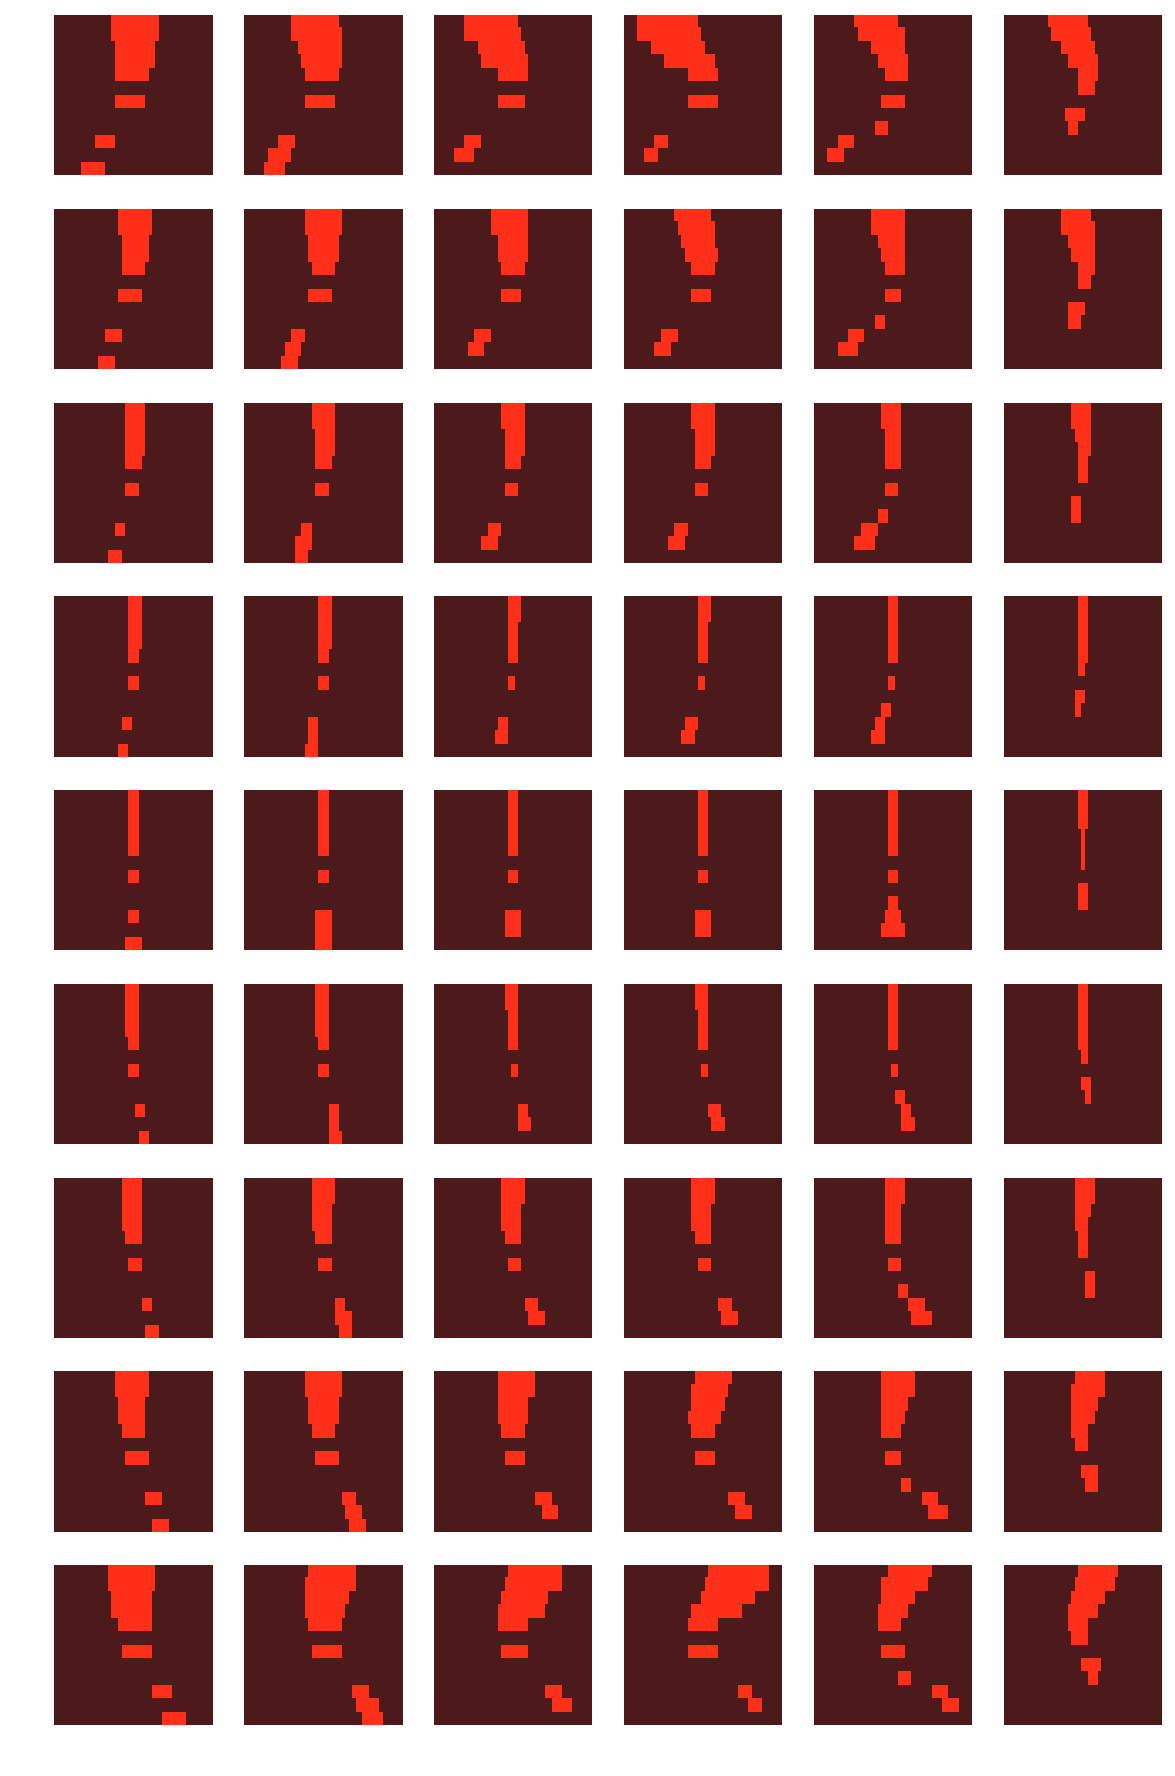

In [33]:
ncols = len(eta_bins)-1
nrows = len(pt_bins)-1

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8,8./ncols*nrows), tight_layout=True, sharex=True, sharey=True)

img1 = None

for i in xrange(nrows):
  for j in xrange(ncols):
    img = np.zeros((nlayers, nbinsx), dtype=np.float32)
    for k in xrange(nlayers):
      if (patterns_phi_2[:,j,k,:] == 0).all():  # skip invalid layers
        continue
      x0, x1 = patterns_phi_2[i,j,k,0], patterns_phi_2[i,j,k,2]
      s1 = slice(x0 + firstbinx, x1 + 1 + firstbinx)  # offset by firstbinx
      k1 = ordered_layer_names.index(layer_names[k])
      img[k1,s1] = 1
      
    if i == 0 and j == 1:
      img1 = img
    
    axs[i,j].imshow(img, origin='lower', interpolation='nearest', aspect='auto',
                    cmap=plt.cm.hot, vmin=-0.2, vmax=2.8, alpha=.9)
    axs[i,j].axis('off')

plt.show()

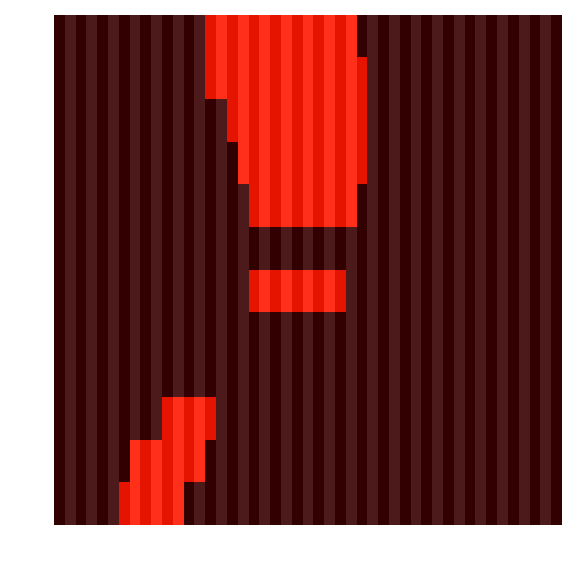

In [34]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,4), tight_layout=True, sharex=True, sharey=True)

stripes = np.zeros_like(img1, dtype=np.int32)
for i in xrange(stripes.shape[1]):
  stripes[:,i] = i % 2
ax.imshow(stripes, cmap=plt.cm.gray, interpolation='nearest', aspect='auto')

ax.imshow(img1, origin='lower', interpolation='nearest', aspect='auto',
          cmap=plt.cm.hot, vmin=-0.2, vmax=2.8, alpha=.9)
ax.axis('off')

plt.show()

In [35]:
# Table, grouped by lay

import pandas as pd

ncols_minor = 3

patterns_phi_pd = patterns_phi_2.copy()
patterns_phi_pd = np.moveaxis(patterns_phi_pd, 2, 0)  # lay -> 1st column
patterns_phi_pd = patterns_phi_pd.reshape((nlayers*nrows,ncols*ncols_minor))

df_index = []
for i in xrange(nlayers):
  for j in xrange(nrows):
    s = '%i_%i' % (i,j)
    df_index.append(s)

df_columns = []
for i in xrange(ncols):
  for j in xrange(ncols_minor):
    s = '%i_%i' % (i,j)
    df_columns.append(s)

df = pd.DataFrame(patterns_phi_pd, index=df_index, columns=df_columns)

In [36]:
def my_highlight(s):
  color = '#eeeeee'
  return 'background-color: %s' % color

df_columns_hl = [df_columns[x] for x in [0,1,2,6+0,6+1,6+2,12+0,12+1,12+2]]
df.style.applymap(my_highlight, subset=pd.IndexSlice[:, df_columns_hl])

,0_0,0_1,0_2,1_0,1_1,1_2,2_0,2_1,2_2,3_0,3_1,3_2,4_0,4_1,4_2,5_0,5_1,5_2
0_0,-11,-9,-6,-13,-11,-9,-14,-12,-10,-14,-13,-11,-16,-14,-12,0,0,0
0_1,-8,-6,-4,-9,-8,-6,-11,-9,-7,-12,-10,-8,-13,-11,-9,0,0,0
0_2,-5,-4,-3,-6,-5,-4,-7,-6,-4,-8,-7,-5,-9,-7,-5,0,0,0
0_3,-3,-2,-1,-4,-3,-2,-4,-3,-2,-5,-4,-2,-5,-4,-3,0,0,0
0_4,-1,0,1,-2,0,2,-2,0,2,-2,0,2,-2,0,2,0,0,0
0_5,1,2,3,2,3,4,2,3,4,2,4,5,3,4,5,0,0,0
0_6,3,4,5,4,5,6,4,6,7,5,7,8,5,7,9,0,0,0
0_7,4,6,8,6,8,9,7,9,11,8,10,12,9,11,13,0,0,0
0_8,6,9,11,9,11,13,10,12,14,11,13,14,12,14,16,0,0,0
1_0,0,0,0,0,0,0,0,0,0,0,0,0,-5,-4,-2,-4,-3,-2


In [37]:
# Lookup

ipt = 3
ieta = 5

rows = ['%i_%i' % (i,ipt) for i in xrange(12)]
columns = ['%i_%i' % (ieta,j) for j in xrange(3)]
df.loc[rows, columns]

,5_0,5_1,5_2
0_3,0,0,0
1_3,-2,-1,-1
2_3,-1,0,1
3_3,-1,0,1
4_3,-1,0,1
5_3,-2,-1,0
6_3,-1,0,0
7_3,-1,0,1
8_3,-1,0,1
9_3,0,0,0


### Save

In [38]:
outfile = 'pattern_bank.npz'
np.savez_compressed(outfile, patterns_phi=patterns_phi_2, patterns_match=patterns_match_1)

In [39]:
with np.load('pattern_bank.npz') as data:
  loaded_patterns_phi = data['patterns_phi']
  loaded_patterns_match = data['patterns_match']

In [40]:
print loaded_patterns_phi.shape
print loaded_patterns_phi[:,1,:5]

(9, 6, 12, 3)
[[[-13 -11  -9]
  [  0   0   0]
  [ -5   0   4]
  [ -6   0   5]
  [ -9  -2   5]]

 [[ -9  -8  -6]
  [  0   0   0]
  [ -3   0   3]
  [ -4   0   4]
  [ -5   0   5]]

 [[ -6  -5  -4]
  [  0   0   0]
  [ -2   0   2]
  [ -2   0   3]
  [ -3   0   3]]

 [[ -4  -3  -2]
  [  0   0   0]
  [ -1   0   1]
  [ -1   0   2]
  [ -1   0   2]]

 [[ -2   0   2]
  [  0   0   0]
  [ -1   0   1]
  [ -1   0   1]
  [ -1   0   1]]

 [[  2   3   4]
  [  0   0   0]
  [ -1   0   1]
  [ -2   0   1]
  [ -2   0   1]]

 [[  4   5   6]
  [  0   0   0]
  [ -2   0   2]
  [ -3   0   2]
  [ -3   0   3]]

 [[  6   8   9]
  [  0   0   0]
  [ -3   0   3]
  [ -4   0   4]
  [ -5   0   5]]

 [[  9  11  13]
  [  0   0   0]
  [ -4   0   5]
  [ -5   0   6]
  [ -5   2   9]]]


In [41]:
print loaded_patterns_match.shape
print loaded_patterns_match[:,1,:5]

(9, 6, 12, 3)
[[[-503 -326 -182]
  [   0    0    0]
  [ 182  326  503]
  [ 106  328  560]
  [ -49  271  552]]

 [[-348 -229 -134]
  [   0    0    0]
  [ 134  229  348]
  [ 119  254  409]
  [  71  241  423]]

 [[-226 -144  -83]
  [   0    0    0]
  [  83  144  226]
  [  84  165  269]
  [  67  164  284]]

 [[-126  -75  -38]
  [   0    0    0]
  [  38   75  126]
  [  41   87  151]
  [  36   88  160]]

 [[ -48    0   49]
  [   0    0    0]
  [ -49    0   48]
  [ -57    0   56]
  [ -60   -1   59]]

 [[  39   75  127]
  [   0    0    0]
  [-127  -75  -39]
  [-152  -88  -43]
  [-161  -89  -38]]

 [[  84  145  228]
  [   0    0    0]
  [-228 -145  -84]
  [-271 -166  -85]
  [-285 -166  -69]]

 [[ 134  230  349]
  [   0    0    0]
  [-349 -230 -134]
  [-409 -253 -120]
  [-423 -241  -74]]

 [[ 182  327  502]
  [   0    0    0]
  [-502 -327 -182]
  [-560 -330 -107]
  [-551 -273   47]]]
